This notebook should be run using: <br>
<code>pyspark --packages org.mongodb.spark:mongo-spark-connector_2.12:10.1.1</code>
so that it works with MongoDB Connector for Spark

In [83]:
# pip install skforecast

In [84]:
sc.master

'local[*]'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import save_model, load_model
from kerastuner.tuners import RandomSearch, GridSearch
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries

from pyspark.sql.functions import date_format
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
write_config = {
    "uri": "mongodb://localhost:27017/CA2.raw_tweets?retryWrites=true&w=majority",
    "database": "CA2",
    "raw_collection": "raw_tweets",
    "modified_collection": "modified_tweets",
    "aggregates_collection": "daily_data",
    "writeConcern.w": "majority"
}

2023-11-16 19:38:10.273451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:38:10.296499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 19:38:10.296524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 19:38:10.296539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 19:38:10.300920: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-16 19:38:10.301207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Using TensorFlow backend


/tmp/ipykernel_6703/894403841.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, GridSearch


In [3]:
hourlyDataSparkDF = spark.read\
    .format("mongodb")\
    .option("uri", write_config["uri"])\
    .option("database", write_config["database"])\
    .option("collection", "hourly_data_imputed")\
    .option("writeConcern.w", write_config["writeConcern.w"])\
    .load()\
    .sort("date")

In [4]:
hourlyDataDF = hourlyDataSparkDF.withColumn("date", date_format("date", "yyyy-MM-dd HH:mm:ss")).toPandas()

In [5]:
hourlyDataDF.head()

,_id,average_sentiment,average_sentiment_knn,date,negative_tweet_ratio,negative_tweet_ratio_knn,neutral_tweet_ratio,neutral_tweet_ratio_knn,positive_tweet_ratio,positive_tweet_ratio_knn
0,6552c4f1d7f5060e848fa7c5,0.087227,0.087227,2009-04-07 00:00:00,0.222798,0.222798,0.340489,0.340489,0.436714,0.436714
1,6552c4f1d7f5060e848fa7c6,0.105966,0.105966,2009-04-07 01:00:00,0.194708,0.194708,0.349975,0.349975,0.455317,0.455317
2,6552c4f1d7f5060e848fa7c7,0.109183,0.109183,2009-04-07 02:00:00,0.198761,0.198761,0.362932,0.362932,0.438307,0.438307
3,6552c4f1d7f5060e848fa7c8,0.108549,0.108549,2009-04-07 03:00:00,0.196099,0.196099,0.359343,0.359343,0.444559,0.444559
4,6552c4f1d7f5060e848fa7c9,0.108544,0.108544,2009-04-07 04:00:00,0.193001,0.193001,0.359491,0.359491,0.447508,0.447508


In [6]:
hourlyDataDF.dtypes

_id                          object
average_sentiment           float64
average_sentiment_knn       float64
date                         object
negative_tweet_ratio        float64
negative_tweet_ratio_knn    float64
neutral_tweet_ratio         float64
neutral_tweet_ratio_knn     float64
positive_tweet_ratio        float64
positive_tweet_ratio_knn    float64
dtype: object

In [7]:
hourlyDataDF['date'] = pd.to_datetime(hourlyDataDF['date'], format='ISO8601')

In [8]:
hourlyDataDF.dtypes

_id                                 object
average_sentiment                  float64
average_sentiment_knn              float64
date                        datetime64[ns]
negative_tweet_ratio               float64
negative_tweet_ratio_knn           float64
neutral_tweet_ratio                float64
neutral_tweet_ratio_knn            float64
positive_tweet_ratio               float64
positive_tweet_ratio_knn           float64
dtype: object

In [9]:
hourlyDataDF.set_index("date", inplace=True)

In [10]:
hourlyDataDF = hourlyDataDF.asfreq('H')

In [11]:
hourlyDataDF.drop("_id", axis=1, inplace=True)
hourlyDataDF.drop("average_sentiment", axis=1, inplace=True)
hourlyDataDF.drop("negative_tweet_ratio", axis=1, inplace=True)
hourlyDataDF.drop("neutral_tweet_ratio", axis=1, inplace=True)
hourlyDataDF.drop("positive_tweet_ratio", axis=1, inplace=True)

In [12]:
hourlyDataDF.head()

,average_sentiment_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn,positive_tweet_ratio_knn
date,,,,
2009-04-07 00:00:00,0.087227,0.222798,0.340489,0.436714
2009-04-07 01:00:00,0.105966,0.194708,0.349975,0.455317
2009-04-07 02:00:00,0.109183,0.198761,0.362932,0.438307
2009-04-07 03:00:00,0.108549,0.196099,0.359343,0.444559
2009-04-07 04:00:00,0.108544,0.193001,0.359491,0.447508


In [13]:
hourlyDataDF.isnull().any()

average_sentiment_knn       False
negative_tweet_ratio_knn    False
neutral_tweet_ratio_knn     False
positive_tweet_ratio_knn    False
dtype: bool

In [14]:
hourlyDataDF.shape

(1909, 4)

### Splitting data into train and test data for the Ridge Regressor

In [15]:
dataTrain = hourlyDataDF.iloc[:1527, :].copy()
dataTest = hourlyDataDF.iloc[1527:, :].copy()

In [16]:
dataTest.shape, dataTrain.shape

((382, 4), (1527, 4))

In [17]:
dataTrain.tail()

,average_sentiment_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn,positive_tweet_ratio_knn
date,,,,
2009-06-09 10:00:00,0.114451,0.190216,0.358957,0.450827
2009-06-09 11:00:00,0.114441,0.190230,0.358955,0.450815
2009-06-09 12:00:00,0.114431,0.190243,0.358952,0.450804
2009-06-09 13:00:00,0.114422,0.190256,0.358950,0.450794
2009-06-09 14:00:00,0.114413,0.190268,0.358948,0.450784


In [18]:
dataTest.head()

,average_sentiment_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn,positive_tweet_ratio_knn
date,,,,
2009-06-09 15:00:00,0.114404,0.190280,0.358946,0.450775
2009-06-09 16:00:00,0.114396,0.190290,0.358944,0.450766
2009-06-09 17:00:00,0.114388,0.190301,0.358942,0.450757
2009-06-09 18:00:00,0.114381,0.190311,0.358940,0.450749
2009-06-09 19:00:00,0.114374,0.190320,0.358939,0.450741


In [19]:
dataTest.tail()

,average_sentiment_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn,positive_tweet_ratio_knn
date,,,,
2009-06-25 08:00:00,-0.000616,0.303650,0.360584,0.335766
2009-06-25 09:00:00,0.002774,0.288407,0.391612,0.319981
2009-06-25 10:00:00,-0.025827,0.325735,0.367275,0.306991
2009-06-25 11:00:00,-0.012120,0.300096,0.391137,0.308767
2009-06-25 12:00:00,-0.045941,0.367089,0.360273,0.272639


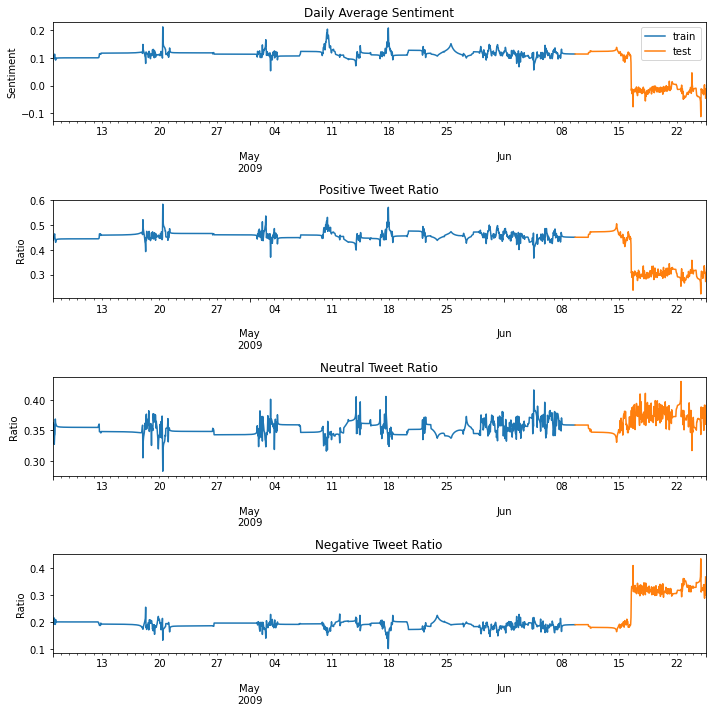

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
dataTrain['average_sentiment_knn'].plot(label='train', ax=axes[0])
dataTest['average_sentiment_knn'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('Sentiment')
axes[0].set_title('Daily Average Sentiment')
axes[0].legend()

dataTrain['positive_tweet_ratio_knn'].plot(label='train', ax=axes[1])
dataTest['positive_tweet_ratio_knn'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('Ratio')
axes[1].set_title('Positive Tweet Ratio')

dataTrain['neutral_tweet_ratio_knn'].plot(label='train', ax=axes[2])
dataTest['neutral_tweet_ratio_knn'].plot(label='test', ax=axes[2])
axes[2].set_xlabel('')
axes[2].set_ylabel('Ratio')
axes[2].set_title('Neutral Tweet Ratio')


dataTrain['negative_tweet_ratio_knn'].plot(label='train', ax=axes[3])
dataTest['negative_tweet_ratio_knn'].plot(label='test', ax=axes[3])
axes[3].set_xlabel('')
axes[3].set_ylabel('Ratio')
axes[3].set_title('Negative Tweet Ratio')


fig.tight_layout()
plt.show();


## Autoregression MultiSeries Training and Prediction

In [216]:
ridgeModel = ForecasterAutoregMultiVariate(
    regressor = Ridge(random_state=42),
    level = 'average_sentiment_knn',
    lags = 24,
    steps = 168,
    transformer_series = None,
    transformer_exog = None,
    weight_func = None,
    n_jobs = 'auto'
)
ridgeModel.fit(series=dataTrain)
ridgeModel

ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 168 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-09 14:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 23:28:14 
Last fit date: 2023-11-14 23:28:15 
Skforecast version: 0.10.1 
Pyt

In [217]:
ridgeModel.training_range

DatetimeIndex(['2009-04-07 00:00:00', '2009-06-09 14:00:00'], dtype='datetime64[ns]', name='date', freq=None)

In [218]:
initialRidgeModelPredictions = ridgeModel.predict()
initialRidgeModelPredictions

,average_sentiment_knn
2009-06-09 15:00:00,0.113661
2009-06-09 16:00:00,0.113862
2009-06-09 17:00:00,0.114049
2009-06-09 18:00:00,0.114209
2009-06-09 19:00:00,0.114324
...,...
2009-06-16 10:00:00,0.116844
2009-06-16 11:00:00,0.116810
2009-06-16 12:00:00,0.116782
2009-06-16 13:00:00,0.116758


### Backtesting the Ridge Model

In [219]:
from tqdm import tqdm as tqdm
metric_levels, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster = ridgeModel,
    series = hourlyDataDF,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

In [220]:
metric_levels

,levels,mean_absolute_error
0,average_sentiment_knn,0.048589


In [221]:
backtest_predictions

,average_sentiment_knn
2009-06-09 15:00:00,0.113661
2009-06-09 16:00:00,0.113862
2009-06-09 17:00:00,0.114049
2009-06-09 18:00:00,0.114209
2009-06-09 19:00:00,0.114324
...,...
2009-06-25 08:00:00,-0.004914
2009-06-25 09:00:00,-0.003337
2009-06-25 10:00:00,-0.003144
2009-06-25 11:00:00,-0.002385


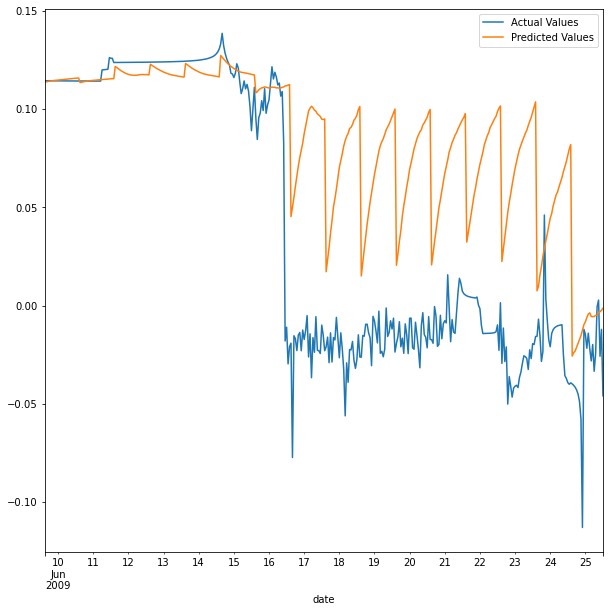

In [222]:
fig, ax = plt.subplots(figsize=(10, 10))
dataTest['average_sentiment_knn'].plot(label="Actual Values", ax=ax)
backtest_predictions["average_sentiment_knn"].plot(label="Predicted Values", ax=ax)
ax.legend()

plt.show()

### Hyperparameter Tuning of the Ridge Regression Model

In [223]:
lags_grid = [24, 48, 72, 96]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = random_search_forecaster_multiseries(
    forecaster = ridgeModel,
    series = hourlyDataDF,
    exog = None,
    lags_grid = lags_grid,
    param_distributions = param_grid,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_iter = 10,
    return_best = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False,
    random_state = 42
)

12 models compared for 1 level(s). Number of iterations: 12.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fol

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.04490578244116124
  Levels: ['average_sentiment_knn']



In [224]:
results

,levels,lags,params,mean_absolute_error,alpha
0,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.044906,0.01
1,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.045589,0.10
2,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.048589,1.00
3,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.050742,0.01
4,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.052120,0.10
6,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.054477,0.01
7,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.055632,0.10
5,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.056218,1.00
8,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.059791,1.00
9,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.062131,0.01


### Standard scaling the data and training the ridge regression model

In [228]:
ridgeStandardScaledModel = ForecasterAutoregMultiVariate(
    regressor = Ridge(random_state=42),
    level = 'average_sentiment_knn',
    lags = 24,
    steps = 168,
    transformer_series = StandardScaler(),
    transformer_exog = None,
    weight_func = None,
    n_jobs = 'auto'
)
ridgeStandardScaledModel.fit(series=dataTrain)
ridgeStandardScaledModel

ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 168 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-09 14:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 23:34:09 
Last fit date: 2023-11-14 23:34:10 
Skforecast version:

In [229]:
initialRidgeSSModelPredictions = ridgeStandardScaledModel.predict()
initialRidgeSSModelPredictions

,average_sentiment_knn
2009-06-09 15:00:00,0.115024
2009-06-09 16:00:00,0.115313
2009-06-09 17:00:00,0.115442
2009-06-09 18:00:00,0.115539
2009-06-09 19:00:00,0.115727
...,...
2009-06-16 10:00:00,0.118436
2009-06-16 11:00:00,0.118285
2009-06-16 12:00:00,0.118133
2009-06-16 13:00:00,0.117952


In [230]:
metric_levels_ss, backtest_predictions_ss = backtesting_forecaster_multiseries(
    forecaster = ridgeStandardScaledModel,
    series = hourlyDataDF,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

In [231]:
metric_levels_ss

,levels,mean_absolute_error
0,average_sentiment_knn,0.044776


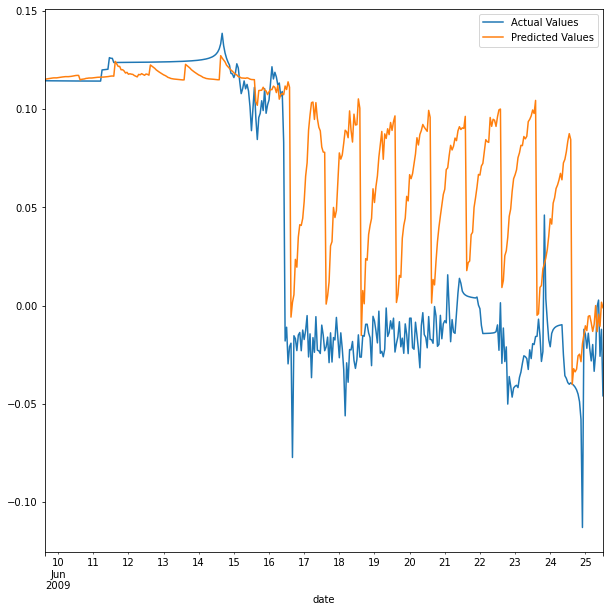

In [232]:
fig, ax = plt.subplots(figsize=(10, 10))
dataTest['average_sentiment_knn'].plot(label="Actual Values", ax=ax)
backtest_predictions_ss["average_sentiment_knn"].plot(label="Predicted Values", ax=ax)
ax.legend()

plt.show()

### Hyperparameter Tuning of the Ridge Regression Standard Scaled Model

In [233]:
lags_grid = [24, 48, 72, 96]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = random_search_forecaster_multiseries(
    forecaster = ridgeStandardScaledModel,
    series = hourlyDataDF,
    exog = None,
    lags_grid = lags_grid,
    param_distributions = param_grid,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_iter = 10,
    return_best = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False,
    random_state = 42
)

12 models compared for 1 level(s). Number of iterations: 12.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fol

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
  Parameters: {'alpha': 0.01}
  Backtesting metric: 0.044733522902954834
  Levels: ['average_sentiment_knn']



In [234]:
results

,levels,lags,params,mean_absolute_error,alpha
0,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.044734,0.01
1,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.044738,0.10
2,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.044776,1.00
3,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.050341,0.01
4,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.050356,0.10
5,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.050467,1.00
6,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.053997,0.01
7,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.054013,0.10
8,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.054139,1.00
9,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.061577,0.01


In [235]:
ridgeStandardScaledModel.predict(5)

,average_sentiment_knn
2009-06-25 13:00:00,-0.024718
2009-06-25 14:00:00,-0.033379
2009-06-25 15:00:00,-0.034245
2009-06-25 16:00:00,-0.039624
2009-06-25 17:00:00,-0.041707


### Saving of model

In [236]:
from skforecast.utils import save_forecaster
save_forecaster(ridgeStandardScaledModel, file_name='ridge1WModel.py', verbose=True)

ForecasterAutoregMultiVariate 
Regressor: Ridge(alpha=0.01, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 168 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 12:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 23:34:09 
Last fit date: 2023-11-14 23:39:14 
Skfore

## 3-month forecast Ridge Regressor Model

This will also be used to forecase 1 week and 1 month

In [200]:
ridge3MModel = ForecasterAutoregMultiVariate(
    regressor = Ridge(random_state=42),
    level = 'average_sentiment_knn',
    lags = 24,
    steps = 1503,
    transformer_series = StandardScaler(),
    transformer_exog = None,
    weight_func = None,
    n_jobs = 'auto'
)
ridge3MModel.fit(series=dataTrain)
ridge3MModel

ForecasterAutoregMultiVariate 
Regressor: Ridge(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 1503 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-09 14:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 22:56:17 
Last fit date: 2023-11-14 22:56:20 
Skforecast version

In [202]:
initialRidge3MPredictions= ridge3MModel.predict()
initialRidge3MPredictions

,average_sentiment_knn
2009-06-09 15:00:00,0.100301
2009-06-09 16:00:00,0.100321
2009-06-09 17:00:00,0.100338
2009-06-09 18:00:00,0.100354
2009-06-09 19:00:00,0.100369
...,...
2009-08-11 01:00:00,0.114451
2009-08-11 02:00:00,0.114441
2009-08-11 03:00:00,0.114431
2009-08-11 04:00:00,0.114422


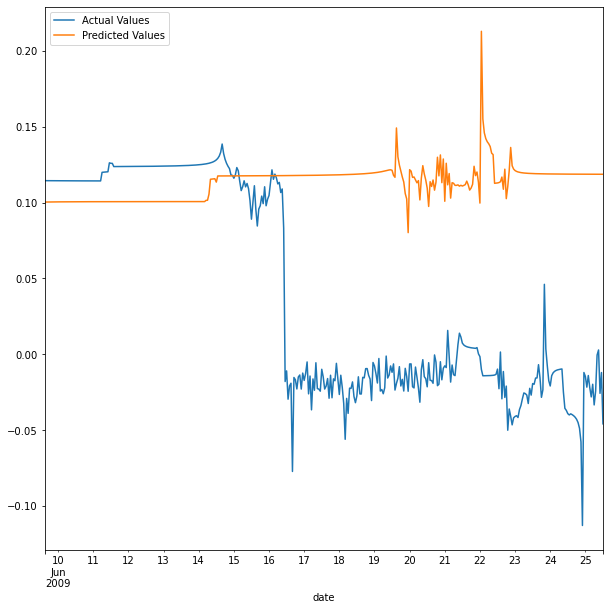

In [206]:
fig, ax = plt.subplots(figsize=(10, 10))
dataTest.loc['2009-06-09 15:00:00' : '2009-06-25 12:00:00' ,'average_sentiment_knn'].plot(label="Actual Values", ax=ax)
initialRidge3MPredictions.loc['2009-06-09 15:00:00' : '2009-06-25 12:00:00', "average_sentiment_knn"].plot(label="Predicted Values", ax=ax)
ax.legend()

plt.show()

In [207]:
metric_levels_3M, backtest_predictions_3M = backtesting_forecaster_multiseries(
    forecaster = ridge3MModel,
    series = hourlyDataDF,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold: 4
    Training:   2009-04-07 00:00:00 -- 2009-06-13 14:00:

In [208]:
metric_levels_3M

,levels,mean_absolute_error
0,average_sentiment_knn,0.047393


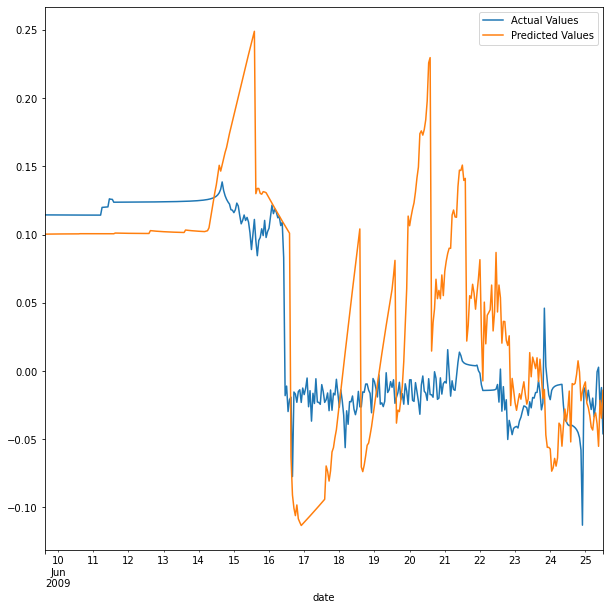

In [209]:
fig, ax = plt.subplots(figsize=(10, 10))
dataTest['average_sentiment_knn'].plot(label="Actual Values", ax=ax)
backtest_predictions_3M["average_sentiment_knn"].plot(label="Predicted Values", ax=ax)
ax.legend()

plt.show()

In [211]:
lags_grid = [24]
param_grid = {'alpha': [0.01, 0.1, 1]}

results = random_search_forecaster_multiseries(
    forecaster = ridge3MModel,
    series = hourlyDataDF,
    exog = None,
    lags_grid = lags_grid,
    param_distributions = param_grid,
    steps = 24,
    metric = 'mean_absolute_error',
    initial_train_size = len(dataTrain),
    fixed_train_size = False,
    gap = 0,
    allow_incomplete_fold = True,
    refit = True,
    n_iter = 10,
    return_best = True,
    n_jobs = 'auto',
    verbose = True,
    show_progress = False,
    random_state = 42
)

3 models compared for 1 level(s). Number of iterations: 3.
Information of backtesting process
----------------------------------
Number of observations used for initial training: 1527
Number of observations used for backtesting: 382
    Number of folds: 16
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 22 observations.

Fold: 0
    Training:   2009-04-07 00:00:00 -- 2009-06-09 14:00:00  (n=1527)
    Validation: 2009-06-09 15:00:00 -- 2009-06-10 14:00:00  (n=24)
Fold: 1
    Training:   2009-04-07 00:00:00 -- 2009-06-10 14:00:00  (n=1551)
    Validation: 2009-06-10 15:00:00 -- 2009-06-11 14:00:00  (n=24)
Fold: 2
    Training:   2009-04-07 00:00:00 -- 2009-06-11 14:00:00  (n=1575)
    Validation: 2009-06-11 15:00:00 -- 2009-06-12 14:00:00  (n=24)
Fold: 3
    Training:   2009-04-07 00:00:00 -- 2009-06-12 14:00:00  (n=1599)
    Validation: 2009-06-12 15:00:00 -- 2009-06-13 14:00:00  (n=24)
Fold:

In [212]:
results

,levels,lags,params,mean_absolute_error,alpha
2,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1},0.047393,1.00
1,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},0.089909,0.10
0,[average_sentiment_knn],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.01},0.170314,0.01


### Saving of model for the dashboard

In [215]:
save_forecaster(ridge3MModel, file_name='ridge3MModel.py', verbose=True)

ForecasterAutoregMultiVariate 
Regressor: Ridge(alpha=1, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 1503 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 12:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 22:56:17 
Last fit date: 2023-11-14 23:19:40 
Skforecast 

Load the ridge 3Month model

In [87]:
ridge3MModel = load_forecaster('ridge3MModel.py', verbose=True)

ForecasterAutoregMultiVariate 
Regressor: Ridge(alpha=1, random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 24 
Target series, level: average_sentiment_knn 
Multivariate series (names): ['average_sentiment_knn', 'negative_tweet_ratio_knn', 'neutral_tweet_ratio_knn', 'positive_tweet_ratio_knn'] 
Maximum steps predicted: 1503 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-04-07 00:00:00'), Timestamp('2009-06-25 12:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-11-14 22:56:17 
Last fit date: 2023-11-14 23:19:40 
Skforecast 

In [111]:
predictions = ridge3MModel.predict(steps=168)

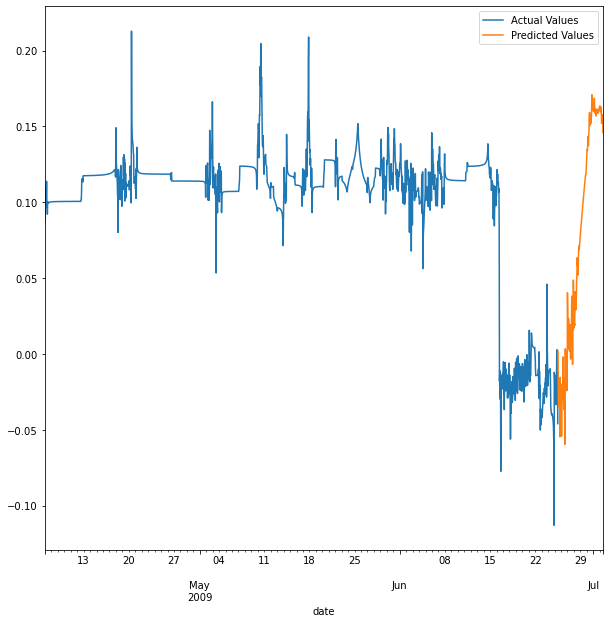

In [112]:
fig, ax = plt.subplots(figsize=(10, 10))
hourlyDataDF['average_sentiment_knn'].plot(label="Actual Values", ax=ax)
predictions["average_sentiment_knn"].plot(label="Predicted Values", ax=ax)
ax.legend()

plt.show()

## LSTM Model

### Prepare the data for the neural network

In [20]:
trainingData = hourlyDataDF.iloc[:1527, :].copy()
testData = hourlyDataDF.iloc[1527:, :].copy()

In [21]:
scaler = MinMaxScaler()
# trainingData["average_sentiment_knn"] = scaler.fit_transform(trainingData[["average_sentiment_knn"]])

In [22]:
trainingData.head()

,average_sentiment_knn,negative_tweet_ratio_knn,neutral_tweet_ratio_knn,positive_tweet_ratio_knn
date,,,,
2009-04-07 00:00:00,0.087227,0.222798,0.340489,0.436714
2009-04-07 01:00:00,0.105966,0.194708,0.349975,0.455317
2009-04-07 02:00:00,0.109183,0.198761,0.362932,0.438307
2009-04-07 03:00:00,0.108549,0.196099,0.359343,0.444559
2009-04-07 04:00:00,0.108544,0.193001,0.359491,0.447508


In [23]:
trainingData.shape, testData.shape

((1527, 4), (382, 4))

In [24]:
def dfToXY(df, window_size = 24):
    df_to_numpy = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_to_numpy) - window_size):
        row = [a for a in df_to_numpy[i:i + window_size]]
        X.append(row)
        label = df_to_numpy[i + window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [25]:
X,y = dfToXY(trainingData)

In [26]:
X.shape, y.shape

((1503, 24, 4), (1503,))

In [27]:
# testData["average_sentiment_knn"] = scaler.fit_transform(testData[["average_sentiment_knn"]])

In [28]:
Xtest, yTest = dfToXY(testData)

In [29]:
Xtest.shape, yTest.shape

((358, 24, 4), (358,))

### Univariate Training and Test Sets

In [30]:
def dfToXYUni(df, window_size = 24):
    df_to_numpy = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_to_numpy) - window_size):
        row = [a for a in df_to_numpy[i:i + window_size]]
        X.append(row)
        label = df_to_numpy[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [31]:
XTrainUni, YTrainUni = dfToXYUni(trainingData["average_sentiment_knn"])

In [32]:
XTrainUni.shape, YTrainUni.shape

((1503, 24), (1503,))

In [33]:
XTestUni, YTestUni = dfToXYUni(testData["average_sentiment_knn"])

In [34]:
XTestUni.shape, YTestUni.shape

((358, 24), (358,))

### Univariate LSTM Model

In [42]:
RNNUni = Sequential()
RNNUni.add(LSTM(units = 214, return_sequences = True, input_shape = (X.shape[1], 1)))
RNNUni.add(Dropout(0.2))
RNNUni.add(LSTM(units = 214))
RNNUni.add(Dropout(0.2))
RNNUni.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.001)
RNNUni.compile(optimizer = opt, loss = 'mae', metrics=["mse"])

In [43]:
RNNUni.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 214)           184896    
                                                                 
 dropout_2 (Dropout)         (None, 24, 214)           0         
                                                                 
 lstm_3 (LSTM)               (None, 214)               367224    
                                                                 
 dropout_3 (Dropout)         (None, 214)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 215       
                                                                 
Total params: 552335 (2.11 MB)
Trainable params: 552335 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = RNNUni.fit(XTrainUni, YTrainUni, epochs = 100, batch_size = 100, validation_data=(XTestUni, YTestUni), verbose=2, shuffle=False)

Epoch 1/100
16/16 - 3s - loss: 0.0283 - mse: 0.0014 - val_loss: 0.0466 - val_mse: 0.0035 - 3s/epoch - 197ms/step
Epoch 2/100
16/16 - 1s - loss: 0.0084 - mse: 1.4248e-04 - val_loss: 0.0483 - val_mse: 0.0037 - 818ms/epoch - 51ms/step
Epoch 3/100
16/16 - 1s - loss: 0.0088 - mse: 1.6045e-04 - val_loss: 0.0461 - val_mse: 0.0031 - 781ms/epoch - 49ms/step
Epoch 4/100
16/16 - 1s - loss: 0.0113 - mse: 2.1940e-04 - val_loss: 0.0479 - val_mse: 0.0036 - 926ms/epoch - 58ms/step
Epoch 5/100
16/16 - 1s - loss: 0.0117 - mse: 2.1580e-04 - val_loss: 0.0489 - val_mse: 0.0036 - 930ms/epoch - 58ms/step
Epoch 6/100
16/16 - 1s - loss: 0.0106 - mse: 1.9021e-04 - val_loss: 0.0496 - val_mse: 0.0038 - 971ms/epoch - 61ms/step
Epoch 7/100
16/16 - 1s - loss: 0.0101 - mse: 1.7397e-04 - val_loss: 0.0496 - val_mse: 0.0039 - 763ms/epoch - 48ms/step
Epoch 8/100
16/16 - 1s - loss: 0.0091 - mse: 1.5402e-04 - val_loss: 0.0474 - val_mse: 0.0035 - 853ms/epoch - 53ms/step
Epoch 9/100
16/16 - 1s - loss: 0.0107 - mse: 1.8953e-0

Epoch 69/100
16/16 - 1s - loss: 0.0053 - mse: 7.0920e-05 - val_loss: 0.0110 - val_mse: 2.6861e-04 - 1s/epoch - 64ms/step
Epoch 70/100
16/16 - 1s - loss: 0.0051 - mse: 6.8229e-05 - val_loss: 0.0148 - val_mse: 3.9570e-04 - 836ms/epoch - 52ms/step
Epoch 71/100
16/16 - 1s - loss: 0.0055 - mse: 7.4289e-05 - val_loss: 0.0177 - val_mse: 5.6556e-04 - 964ms/epoch - 60ms/step
Epoch 72/100
16/16 - 1s - loss: 0.0056 - mse: 7.4398e-05 - val_loss: 0.0135 - val_mse: 3.7102e-04 - 820ms/epoch - 51ms/step
Epoch 73/100
16/16 - 1s - loss: 0.0066 - mse: 8.9398e-05 - val_loss: 0.0150 - val_mse: 4.4214e-04 - 825ms/epoch - 52ms/step
Epoch 74/100
16/16 - 1s - loss: 0.0066 - mse: 8.6875e-05 - val_loss: 0.0190 - val_mse: 6.4932e-04 - 889ms/epoch - 56ms/step
Epoch 75/100
16/16 - 1s - loss: 0.0060 - mse: 7.9261e-05 - val_loss: 0.0144 - val_mse: 4.1182e-04 - 871ms/epoch - 54ms/step
Epoch 76/100
16/16 - 1s - loss: 0.0064 - mse: 8.7151e-05 - val_loss: 0.0155 - val_mse: 4.6953e-04 - 841ms/epoch - 53ms/step
Epoch 77/10

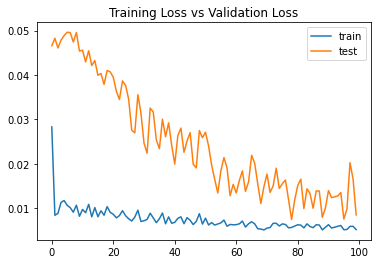

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()

In [49]:
predictions = RNNUni.predict(XTestUni)

12/12 [==============================] - 0s 14ms/step


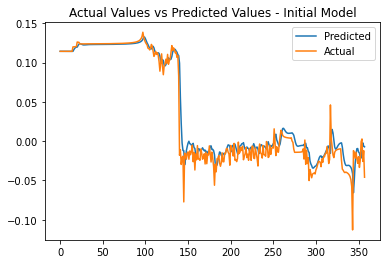

In [50]:
plt.plot(predictions, label='Predicted')
plt.plot(YTestUni, label='Actual')
plt.legend()
plt.title("Actual Values vs Predicted Values - Initial Model")
plt.show()

In [51]:
history.history['val_loss'][len(history.history['val_loss'])-1], history.history['val_mse'][len(history.history['val_mse'])-1]

(0.008467024192214012, 0.00020745881192851812)

In [52]:
save_model(RNNUni, "LSTMUni")

INFO:tensorflow:Assets written to: LSTMUni/assets


tensorflow INFO  Assets written to: LSTMUni/assets


### Hyperparameter Tuning the LSTM Univariate Model

In [53]:
def buildModelUni(hp):
    RNN = Sequential()
    RNN.add(LSTM(hp.Int('input_unit', min_value=150, max_value=214, step=32, default=214), return_sequences = True, input_shape = (X.shape[1], 1)))
    RNN.add(Dropout(0.2))
    RNN.add(LSTM(hp.Int('2nd_neurons', min_value=150, max_value=214, step=32, default=214)))
    RNN.add(Dropout(0.2))
    RNN.add(Dense(1))

    opt = keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[0.001, 0.1, 0.01,], default=0.001))
    RNN.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=["mse"])
    return RNN

In [54]:
tuner = RandomSearch(
    buildModelUni,
    objective='mae',
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    max_consecutive_failed_trials=5
)

In [55]:
tuner.search(
    x=XTrainUni,
    y=YTrainUni,
    epochs=50,
    batch_size=100,
    validation_data=(XTestUni, YTestUni),
)

Trial 4 Complete [00h 00m 48s]

Best mae So Far: None
Total elapsed time: 00h 02m 53s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
182               |150               |input_unit
182               |150               |2nd_neurons
0.01              |0.1               |learning_rate

Epoch 1/50
16/16 [==============================] - 3s 76ms/step - loss: 0.0999 - mse: 0.0241 - val_loss: 0.0771 - val_mse: 0.0087
Epoch 2/50
16/16 [==============================] - 1s 51ms/step - loss: 0.0105 - mse: 2.1722e-04 - val_loss: 0.0803 - val_mse: 0.0099
Epoch 3/50
16/16 [==============================] - 1s 46ms/step - loss: 0.0092 - mse: 1.7357e-04 - val_loss: 0.0885 - val_mse: 0.0120
Epoch 4/50
16/16 [==============================] - 1s 48ms/step - loss: 0.0119 - mse: 2.4521e-04 - val_loss: 0.0904 - val_mse: 0.0125
Epoch 5/50
16/16 [==============================] - 1s 47ms/step - loss: 0.0117 - mse: 2.3984e-04 - val_loss: 0.0799 - val_mse: 0.0094
Epoch 6/50


Traceback (most recent call last):
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 261, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 228, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 228, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 241, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File 

RuntimeError: Number of consecutive failures exceeded the limit of 5.
Traceback (most recent call last):
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 261, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 228, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 228, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 241, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/tuner_utils.py", line 212, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
  File "/home/hduser/.local/lib/python3.10/site-packages/keras_tuner/src/engine/objective.py", line 57, in get_value
    return logs[self.name]
KeyError: 'mae'


In [74]:
GridTuner = GridSearch(
    buildModelUni,
    objective='mae',
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    max_consecutive_failed_trials=5
)

In [76]:
GridTuner.search(
    x=XTrainUni,
    y=YTrainUni,
    epochs=100,
    batch_size=100,
    validation_data=(XTestUni, YTestUni),
)

Trial 3 Complete [00h 01m 40s]

Best mae So Far: None
Total elapsed time: 00h 05m 54s


In [77]:
bestUniModel = GridTuner.get_best_models()[0]

In [78]:
uniBestPred = bestUniModel.predict(XTestUni)

12/12 [==============================] - 1s 12ms/step


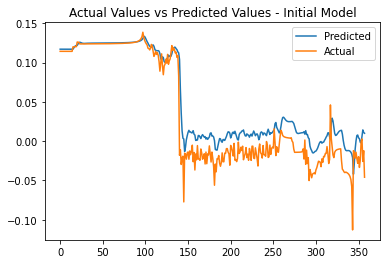

In [79]:
plt.plot(uniBestPred, label='Predicted')
plt.plot(YTestUni, label='Actual')
plt.legend()
plt.title("Actual Values vs Predicted Values - Initial Model")
plt.show()

In [80]:
metric = bestUniModel.evaluate(XTestUni, YTestUni, return_dict=True)
metric

12/12 [==============================] - 1s 13ms/step - loss: 0.0172 - mse: 5.4828e-04


{'loss': 0.017242129892110825, 'mse': 0.0005482812994159758}

In [81]:
bestHP = tuner.get_best_hyperparameters()[0]
bestHP.values

{'input_unit': 150, '2nd_neurons': 150, 'learning_rate': 0.1}

In [82]:
save_model(bestUniModel, "LSTMBestUni")

INFO:tensorflow:Assets written to: LSTMBestUni/assets


tensorflow INFO  Assets written to: LSTMBestUni/assets


### Multivariate LSTM Model

In [32]:
def buildModel(hp):
    RNN = Sequential()
    RNN.add(LSTM(hp.Int('input_unit', min_value=150, max_value=214, step=32), return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
    RNN.add(Dropout(0.2))
    RNN.add(LSTM(hp.Int('2nd_neurons', min_value=150, max_value=214, step=32)))
    RNN.add(Dropout(0.2))
    RNN.add(Dense(1))

    opt = keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[0.1, 1.0, 0.01, 0.001], default=0.01))
    RNN.compile(optimizer = opt, loss = 'mae', metrics=["mse"])
    return RNN

In [33]:
RNN = Sequential()
RNN.add(LSTM(units = 150, return_sequences = True, input_shape = (X.shape[1], X.shape[2])))
RNN.add(Dropout(0.2))
RNN.add(LSTM(units = 150))
RNN.add(Dropout(0.2))
RNN.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.001)
RNN.compile(optimizer = opt, loss = 'mae', metrics=["mse"])

In [34]:
RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 150)           93000     
                                                                 
 dropout (Dropout)           (None, 24, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 273751 (1.04 MB)
Trainable params: 273751 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history = RNN.fit(X, y, epochs = 100, batch_size = 100, validation_data=(Xtest, yTest), verbose=2, shuffle=False)

Epoch 1/100
16/16 - 3s - loss: 0.0330 - mse: 0.0022 - val_loss: 0.0704 - val_mse: 0.0078 - 3s/epoch - 206ms/step
Epoch 2/100
16/16 - 1s - loss: 0.0134 - mse: 3.0646e-04 - val_loss: 0.0607 - val_mse: 0.0055 - 581ms/epoch - 36ms/step
Epoch 3/100
16/16 - 1s - loss: 0.0140 - mse: 3.2178e-04 - val_loss: 0.0601 - val_mse: 0.0057 - 569ms/epoch - 36ms/step
Epoch 4/100
16/16 - 1s - loss: 0.0115 - mse: 2.3298e-04 - val_loss: 0.0535 - val_mse: 0.0043 - 582ms/epoch - 36ms/step
Epoch 5/100
16/16 - 1s - loss: 0.0145 - mse: 3.2676e-04 - val_loss: 0.0567 - val_mse: 0.0051 - 549ms/epoch - 34ms/step
Epoch 6/100
16/16 - 1s - loss: 0.0105 - mse: 1.9890e-04 - val_loss: 0.0511 - val_mse: 0.0038 - 577ms/epoch - 36ms/step
Epoch 7/100
16/16 - 1s - loss: 0.0135 - mse: 2.9441e-04 - val_loss: 0.0579 - val_mse: 0.0052 - 547ms/epoch - 34ms/step
Epoch 8/100
16/16 - 1s - loss: 0.0099 - mse: 1.8458e-04 - val_loss: 0.0503 - val_mse: 0.0040 - 576ms/epoch - 36ms/step
Epoch 9/100
16/16 - 1s - loss: 0.0092 - mse: 1.6438e-0

Epoch 69/100
16/16 - 1s - loss: 0.0058 - mse: 8.0709e-05 - val_loss: 0.0144 - val_mse: 4.3554e-04 - 611ms/epoch - 38ms/step
Epoch 70/100
16/16 - 1s - loss: 0.0061 - mse: 8.5801e-05 - val_loss: 0.0132 - val_mse: 3.7317e-04 - 579ms/epoch - 36ms/step
Epoch 71/100
16/16 - 1s - loss: 0.0057 - mse: 7.7795e-05 - val_loss: 0.0109 - val_mse: 2.8956e-04 - 557ms/epoch - 35ms/step
Epoch 72/100
16/16 - 1s - loss: 0.0058 - mse: 7.7972e-05 - val_loss: 0.0102 - val_mse: 2.6854e-04 - 584ms/epoch - 37ms/step
Epoch 73/100
16/16 - 1s - loss: 0.0059 - mse: 7.9553e-05 - val_loss: 0.0077 - val_mse: 1.9786e-04 - 567ms/epoch - 35ms/step
Epoch 74/100
16/16 - 1s - loss: 0.0061 - mse: 8.3693e-05 - val_loss: 0.0209 - val_mse: 7.3913e-04 - 580ms/epoch - 36ms/step
Epoch 75/100
16/16 - 1s - loss: 0.0059 - mse: 8.0650e-05 - val_loss: 0.0183 - val_mse: 6.3486e-04 - 602ms/epoch - 38ms/step
Epoch 76/100
16/16 - 1s - loss: 0.0062 - mse: 8.7037e-05 - val_loss: 0.0154 - val_mse: 4.8051e-04 - 617ms/epoch - 39ms/step
Epoch 77

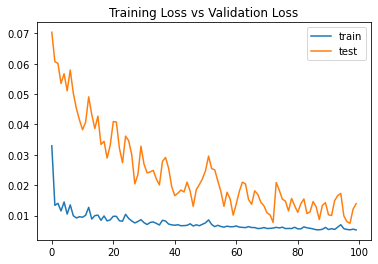

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()

In [37]:
predictions = RNN.predict(Xtest)

12/12 [==============================] - 0s 8ms/step


In [38]:
len(predictions), predictions.shape

(358, (358, 1))

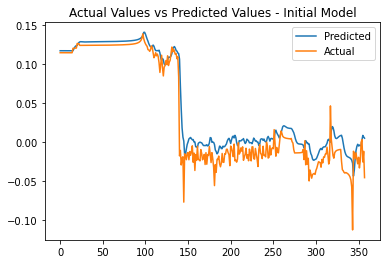

In [39]:
plt.plot(predictions, label='Predicted')
plt.plot(yTest, label='Actual')
plt.legend()
plt.title("Actual Values vs Predicted Values - Initial Model")
plt.show()

In [40]:
Xtest.shape

(358, 24, 4)

In [52]:
tuner= RandomSearch(
    buildModel,
    objective='mae',
    max_trials=3,
    executions_per_trial=1
)

Reloading Tuner from ./untitled_project/tuner0.json


In [53]:
tuner.search(
    x=X,
    y=y,
    epochs=100,
    batch_size=100,
    validation_data=(Xtest, yTest),
)

Trial 3 Complete [00h 01m 30s]

Best mae So Far: 6.252060120459646e-05
Total elapsed time: 00h 01m 30s


In [69]:
best_model = tuner.get_best_models(num_models=1)[0]

In [55]:
bm_predictions = best_model.predict(Xtest)

12/12 [==============================] - 0s 12ms/step


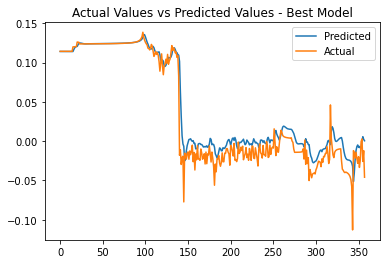

In [56]:
plt.plot(bm_predictions, label='Predicted')
plt.plot(yTest, label='Actual')
plt.legend()
plt.title("Actual Values vs Predicted Values - Best Model")
plt.show()

In [46]:
save_model(best_model, "LSTMModel")

INFO:tensorflow:Assets written to: LSTMModel/assets


tensorflow INFO  Assets written to: LSTMModel/assets


In [63]:
metric = best_model.evaluate(Xtest, yTest, return_dict=True)

12/12 [==============================] - 0s 11ms/step - loss: 0.0111 - mse: 2.9777e-04


In [65]:
metric

{'loss': 0.011144143529236317, 'mse': 0.0002977715339511633}

## LSTM Forecast Multiple Days (Univariate)

## Training Data
This time, the "label" data will 168 hours (1 week) forecast.

In [21]:
lookback = 168
forecast = 168

In [22]:
# trainingData = hourlyDataDF.iloc[:1527, :].copy()
# testData = hourlyDataDF.iloc[1527:, :].copy()

# y = trainingData["average_sentiment_knn"]
# y = y.values.reshape(-1, 1)
# yt = testData["average_sentiment_knn"].values.reshape(-1, 1)

y = hourlyDataDF["average_sentiment_knn"].values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(y)
# y = scaler.transform(y)

Get the training data

In [23]:
XTrain = []
YTrain = []

for i in range(lookback, len(y) - forecast + 1):
    XTrain.append(y[i - lookback: i])
    YTrain.append(y[i: i + forecast])
    
XTrain = np.array(XTrain)
YTrain = np.array(YTrain)

In [24]:
# XTest = []
# YTest = []

# for i in range(lookback, len(y) - forecast + 1):
#     XTest.append(y[i - lookback: i])
#     YTest.append(y[i: i + forecast])
    
# XTest = np.array(XTest)
# YTest = np.array(YTest)

In [26]:
XTrain.shape, YTrain.shape

((1574, 168, 1), (1574, 168, 1))

This LSTM will return the forecasted 168 hours.

In [27]:
RNNMulti = Sequential()
RNNMulti.add(LSTM(units = 50, input_shape = (lookback, 1)))
RNNMulti.add(Dropout(0.2))
RNNMulti.add(Dense(50, activation="relu"))
RNNMulti.add(Dropout(0.2))
RNNMulti.add(Dense(forecast))

opt = keras.optimizers.Adam(learning_rate=0.001)
RNNMulti.compile(optimizer = opt, loss = 'mae', metrics=["mse"])

In [28]:
RNNMulti.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 168)               8568      
                                                                 
Total params: 21518 (84.05 KB)
Trainable params: 21518 (84.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history = RNNMulti.fit(XTrain, YTrain, epochs = 20, batch_size = 100, verbose=2, shuffle=False)

Epoch 1/20
16/16 - 2s - loss: 0.0970 - mse: 0.0106 - 2s/epoch - 101ms/step
Epoch 2/20
16/16 - 1s - loss: 0.0552 - mse: 0.0048 - 612ms/epoch - 38ms/step
Epoch 3/20
16/16 - 1s - loss: 0.0370 - mse: 0.0026 - 629ms/epoch - 39ms/step
Epoch 4/20
16/16 - 1s - loss: 0.0307 - mse: 0.0021 - 651ms/epoch - 41ms/step
Epoch 5/20
16/16 - 1s - loss: 0.0277 - mse: 0.0019 - 633ms/epoch - 40ms/step
Epoch 6/20
16/16 - 1s - loss: 0.0258 - mse: 0.0017 - 625ms/epoch - 39ms/step
Epoch 7/20
16/16 - 1s - loss: 0.0246 - mse: 0.0017 - 695ms/epoch - 43ms/step
Epoch 8/20
16/16 - 1s - loss: 0.0240 - mse: 0.0016 - 649ms/epoch - 41ms/step
Epoch 9/20
16/16 - 1s - loss: 0.0229 - mse: 0.0016 - 623ms/epoch - 39ms/step
Epoch 10/20
16/16 - 1s - loss: 0.0222 - mse: 0.0015 - 612ms/epoch - 38ms/step
Epoch 11/20
16/16 - 1s - loss: 0.0217 - mse: 0.0015 - 634ms/epoch - 40ms/step
Epoch 12/20
16/16 - 1s - loss: 0.0211 - mse: 0.0014 - 652ms/epoch - 41ms/step
Epoch 13/20
16/16 - 1s - loss: 0.0210 - mse: 0.0014 - 657ms/epoch - 41ms/st

In [30]:
save_model(RNNMulti, "LSTMMultiDay")

INFO:tensorflow:Assets written to: LSTMMultiDay/assets


tensorflow INFO  Assets written to: LSTMMultiDay/assets


In [31]:
RNNMulti = load_model("LSTMMultiDay")

In [33]:
XForecast = y[-lookback:]  # last available input sequence
XForecast = XForecast.reshape(1, lookback, 1)

In [35]:
predicted = RNNMulti.predict(XForecast).reshape(-1, 1)
# predicted_unscaled = scaler.inverse_transform(predicted)


1/1 [==============================] - 0s 17ms/step


In [36]:
df = pd.DataFrame(columns=["Predicted"])

In [38]:
df["predicted"] = predicted.flatten()

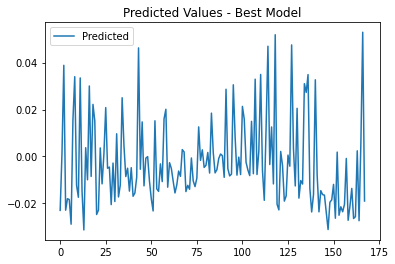

In [39]:
plt.plot(df["predicted"], label='Predicted')
# plt.plot(hourlyDataDF["average_sentiment_knn"].values, label='Actual')
plt.legend()
plt.title("Predicted Values - Best Model")
plt.show()